# Try SNPE with sbi package

In [ ]:
#Simple example
from sbi.examples.minimal import simple
posterior = simple()
print(posterior)

Define siulator

In [1]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

#Define the simulator!
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

# epsilon = 150 NOT NEEDED Error threshold used in kernel, higher than 2 params
# num_samples = 10000 NOT NEEDED # Number of samples to draw

In [2]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer

In [3]:
num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    return solution
    
posterior = infer(simulator, prior, method="SNPE", num_simulations=500)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 104 epochs.


In [4]:
print(posterior)

Posterior conditional density p(θ|x) (amortized).

This DirectPosterior-object was obtained with a SNPE-class method using a flow.
It allows to .sample() and .log_prob() the posterior and wraps the output of the .net to avoid leakage into regions with 0 prior probability.


In [5]:
observation = torch.tensor(true_data)
observation.shape

torch.Size([1000, 6])

In [6]:
# Add a batch dimension to the observation
batch_size = 1
batched_tensor = observation.unsqueeze(0).expand(batch_size, -1, -1)
batched_tensor.shape

torch.Size([1, 1000, 6])

In [7]:
inferred_batch_shape, *inferred_data_shape = batched_tensor.shape
inferred_batch_shape

1

In [8]:
posterior_samples = posterior.sample((10000,), x=batched_tensor)

AssertionError: Observed data shape (torch.Size([1, 1000, 6])) must match the shape of simulated data x (torch.Size([1, 6000])).

We have got the simulations of different trajectories in one dimension only! Try to simulate in 6 dimensions, each trajectory separately

In [32]:
#unnecessarily complicated way
num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
        # Create an empty tensor to store simulated data
    simulated_data = torch.zeros(batch_size, num_timesteps, num_trajectories)
    for i in range(batch_size):
        for j in range(num_trajectories):
            # Simulate data for each trajectory using the parameters
            # Replace this with your actual simulation code
            # Example: generate trajectory data from a Gaussian distribution
            for t in range(num_timesteps):
                
                trajectory_data = solution[t][j]
            simulated_data[i, j, :] = trajectory_data

    return simulated_data

SyntaxError: 'return' outside function (1484584955.py, line 24)

In [26]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=500)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 198 epochs.


In [37]:
#better way
num_dim = 2
num_timesteps = 1000
prior = utils.BoxUniform(low=-3 * torch.ones(num_dim), high=3 * torch.ones(num_dim))
batch_size = 1
num_trajectories = 6

def simulator(parameter_set):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    t = np.linspace(0, 100, num_timesteps)
    solution = odeint(model, initial_conditions, t, args=(parameter_set,))
    batch_size = 1
    solution_tensor = torch.tensor(solution)
    solution_tensor_reshaped = solution_tensor.unsqueeze(0).expand(batch_size, -1, -1)
    return solution_tensor_reshaped

In [38]:
posterior = infer(simulator, prior, method="SNPE", num_simulations=500)

/project/home23/sg2023/Desktop/SBI/.conda/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:242: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  output = _odepack.odeint(func, y0, t, args, Dfun, col_deriv, ml, mu,


Running 500 simulations.:   0%|          | 0/500 [00:00<?, ?it/s]

Neural network successfully converged after 111 epochs.


In [33]:
true_data

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  8.91234488,   1.3647686 ,  12.9051011 ,   3.48115   ,
         42.90834925,   4.05007984],
       [ 13.87025443,   2.35055077,  14.41501444,   4.48617343,
         61.6268512 ,   8.82894233],
       ...,
       [ 46.99593722, 113.75256467,  56.88822485,  25.99888049,
          1.26097754,   2.73142618],
       [ 42.7397636 , 107.18456261,  63.37554762,  29.2513315 ,
          1.24394087,   2.5905151 ],
       [ 38.86297696, 100.85538635,  70.36354634,  32.83617667,
          1.2295278 ,   2.46153137]])

In [36]:
# Add a batch dimension to the observation
batch_size = 1
observation = torch.tensor(true_data)
true_tensor = observation.unsqueeze(0).expand(batch_size, -1, -1)
true_tensor

tensor([[[  0.0000,   1.0000,   0.0000,   3.0000,   0.0000,   2.0000],
         [  8.9123,   1.3648,  12.9051,   3.4811,  42.9083,   4.0501],
         [ 13.8703,   2.3506,  14.4150,   4.4862,  61.6269,   8.8289],
         ...,
         [ 46.9959, 113.7526,  56.8882,  25.9989,   1.2610,   2.7314],
         [ 42.7398, 107.1846,  63.3755,  29.2513,   1.2439,   2.5905],
         [ 38.8630, 100.8554,  70.3635,  32.8362,   1.2295,   2.4615]]],
       dtype=torch.float64)

In [ ]:
true_data_torch = torch.zeros(batch_size, num_timesteps, num_trajectories)
for i in range(batch_size):
    for j in range(num_trajectories):
        # Simulate data for each trajectory using the parameters
        # Replace this with your actual simulation code
        # Example: generate trajectory data from a Gaussian distribution
        for t in range(num_timesteps):
            trajectory_data = []
            trajectory_data = true_data[t][j]
        true_data_torch[i, j, :] = trajectory_data

In [39]:
posterior_samples = posterior.sample((10000,), x=true_tensor)

AssertionError: Observed data shape (torch.Size([1, 1000, 6])) must match the shape of simulated data x (torch.Size([1, 6000])).

Posterior simulated samples are always of a shape 1,6000 for some reason... try to make true data like that to see what happens

In [42]:
true_data

array([[  0.        ,   1.        ,   0.        ,   3.        ,
          0.        ,   2.        ],
       [  8.91234488,   1.3647686 ,  12.9051011 ,   3.48115   ,
         42.90834925,   4.05007984],
       [ 13.87025443,   2.35055077,  14.41501444,   4.48617343,
         61.6268512 ,   8.82894233],
       ...,
       [ 46.99593722, 113.75256467,  56.88822485,  25.99888049,
          1.26097754,   2.73142618],
       [ 42.7397636 , 107.18456261,  63.37554762,  29.2513315 ,
          1.24394087,   2.5905151 ],
       [ 38.86297696, 100.85538635,  70.36354634,  32.83617667,
          1.2295278 ,   2.46153137]])

In [44]:
true_merged = []
for i in range(len(true_data)):
    for j in range(6):
        true_merged.append(true_data[i][j])
true_merged

[0.0,
 1.0,
 0.0,
 3.0,
 0.0,
 2.0,
 8.912344880225271,
 1.364768604548303,
 12.905101102689697,
 3.4811499980725817,
 42.90834924665272,
 4.050079844140272,
 13.8702544328508,
 2.3505507687326883,
 14.41501443927035,
 4.486173431994887,
 61.62685119720332,
 8.82894232576309,
 16.381726213365596,
 3.5826794239343753,
 13.887178974466751,
 5.411775494669261,
 65.90823881513367,
 14.13185983467769,
 17.663957372531595,
 4.8708210865546295,
 13.008512636653734,
 6.177567559270426,
 64.85481122674577,
 19.036718279628783,
 18.284778358485823,
 6.123322488162355,
 12.077320487243721,
 6.783117464849966,
 61.84370702595983,
 23.26418650329569,
 18.53028029921149,
 7.295849310758269,
 11.173831544838997,
 7.243295217158478,
 58.122514230567845,
 26.761797747825423,
 18.55947914788647,
 8.368649174735667,
 10.324324573607191,
 7.576080499846585,
 54.2094049891088,
 29.55986040828502,
 18.46794959219733,
 9.335604054904968,
 9.537183871961144,
 7.799238702366783,
 50.34025947372969,
 31.7195456

In [59]:
#just making sure we get bad results if we merge in another way:
m1 = []
p1 = []
m2 = []
p2 = []
m3 = []
p3 = []
for timepoint in true_data:
    m1.append(timepoint[0])
    p1.append(timepoint[1])
    m2.append(timepoint[2])
    p2.append(timepoint[3])
    m3.append(timepoint[4])
    p3.append(timepoint[5])

true_merged2 = []
true_merged2.append(m1)
true_merged2.append(p1)
true_merged2.append(m2)
true_merged2.append(p2)
true_merged2.append(m3)
true_merged2.append(p3)

merged_list = [item for sublist in true_merged2 for item in sublist]


6000

In [45]:
true_merged_tensor = torch.tensor(true_merged)
true_merged_tensor.shape

torch.Size([6000])

In [46]:
posterior_samples = posterior.sample((10000,), x=true_merged_tensor)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

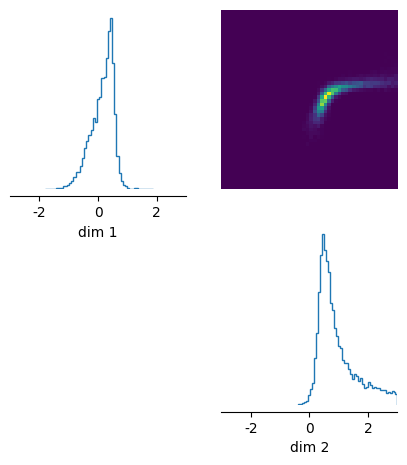

In [47]:
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

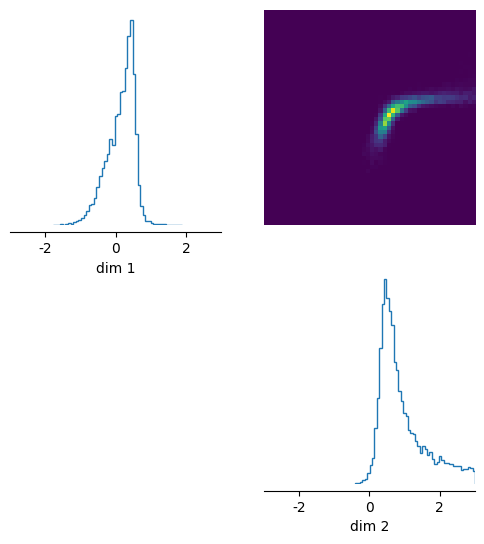

In [49]:
log_probability = posterior.log_prob(posterior_samples, x=true_merged_tensor)
_ = analysis.pairplot(posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(6, 6))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

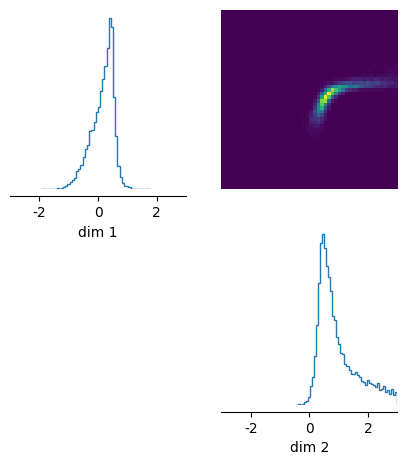

In [60]:
#alternative merging:
merged_list_tensor = torch.tensor(merged_list)
posterior_samples = posterior.sample((10000,), x=true_merged_tensor)
_ = analysis.pairplot(
    posterior_samples, limits=[[-3, 3], [-3, 3]], figsize=(5, 5)
)

In [5]:
from sbi.inference import SNPE_A

inference = SNPE_A(prior)
proposal = prior

for _ in range(rounds):
    theta = proposal.sample((num_sims,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior().set_default_x(x_o)
    proposal = posterior

NameError: name 'prior' is not defined